In [387]:
import random
import os
import numpy as np
import pandas as pd
import torch
import glob
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
!pip install ray[tune]

In [345]:
from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import transforms
import torchvision

In [3]:
from tabulate import tabulate as tb

In [381]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [385]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

In [5]:
PATH_DELIMITER = '/'

In [605]:
class LetterImageDataset(torch.utils.data.Dataset):
  def __init__(self, images_path, image_filter='**/*.jpg', 
               gray_scale=True, recursive=True):  
    self.__image_files = glob.glob(images_path + '/' + image_filter, recursive=recursive)
    gray_scale_channels = 1 if gray_scale else 3
    self.__transform =  transforms.Compose([transforms.Lambda(lambda x: np.transpose(x, axes=(1, 0, 2))),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                            transforms.Grayscale(num_output_channels=gray_scale_channels),
                                            transforms.Lambda(lambda x: x.float())])

  @staticmethod
  def __get_label(imgae_path: str) -> int:
    file_name_start_index = imgae_path.rfind(PATH_DELIMITER)
    label_char = imgae_path[file_name_start_index + 1 :][0]
    return int(ord(label_char) - 97)
  
  def __len__(self):
    return len(self.__image_files)

  def __getitem__(self, index) -> tuple:
    cur_path = self.__image_files[index]
    image = np.asarray(Image.open(cur_path))
    image = self.__transform(image)
    label = self.__get_label(cur_path)
    return image, label

def get_letter_from_label(label) -> chr:
  return chr(int(label) + 97)

In [259]:
DATASET_PATH = os.path.abspath("./Documents/images")
DATASET_PATH

'/Users/sanduser/Documents/images'

In [261]:
dataset = LetterImageDataset(f"{DATASET_PATH}/train")
print(f"Train data size: {len(dataset)}")

Train data size: 65000


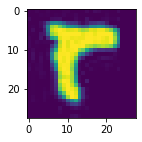

Label:  17 (r)


In [262]:
image_exmp, label_exmp = dataset[0]
plt.figure(figsize=(2,2))
plt.imshow(image_exmp.T)
plt.show()
print('Label: ', label_exmp, f"({get_letter_from_label(label_exmp)})")

# Create train utilities

## Model training

In [340]:
preprocess = transforms.Compose([transforms.Lambda(lambda x: np.transpose(x, axes=(1, 0, 2))),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                 transforms.Grayscale(num_output_channels=1),
                                 transforms.Lambda(lambda x: x.float())])

In [606]:
def train_model(model: torch.nn.Module, 
                criterion, optimizer, data_dir: str,
                epochs: int, batch_size: int, 
                report_step: int, train_split_precent: float,
                checkpoint_path: str,
                gray_scale=True):

    # Choose device
    device = "cpu" if not torch.cuda.is_available() else "cuda:0"
    model.to(device)

    # Define data loaders
    train_dataset = LetterImageDataset(f"{data_dir}/train", gray_scale=gray_scale)

    train_size = int(len(train_dataset) * train_split_precent)
    train_subset, val_subset = random_split(train_dataset, 
                                            [train_size, len(train_dataset) - train_size])

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(batch_size),
        shuffle=True)
  
    valid_loader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(batch_size),
        shuffle=True)

    # Train
    iteration = 0
    train_info = {
        'loss': [],
        'iteration': [],
        'accuracy': [],
    }
    for epoch in range(epochs):
        model.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = model(inputs)

            # optimize
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Validate
            if iteration % report_step == 0:
                val_loss = []
                val_labels = []
                val_predicted = []
                model.eval()
                with torch.no_grad():
                    for i, data in enumerate(valid_loader):
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)
                        # predict
                        outputs = model(inputs)
                        _, predicted = torch.max(outputs.data, 1)
                        #loss
                        loss = criterion(outputs, labels)
                        # for metrics
                        val_labels += labels.tolist()
                        val_predicted += predicted.tolist()
                        # MISHAS
                        val_loss.append(loss.numpy())
                # Calculate metric
                acc = accuracy_score(val_labels, val_predicted)
                # Log
                train_info['loss'].append(loss.data)
                train_info['iteration'].append(iteration)
                train_info['accuracy'].append(acc)
                print(f"[ Epoch: {epoch} | Iteration: {iteration} | Loss train: {loss.data} | Loss val: {np.mean(val_loss)} | Acc: {acc}]")
                # Checkpoint
                torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'loss': loss.data,
                            }, checkpoint_path)

            iteration += 1

    print("Finished Training")

## Test validation

In [608]:
def test_validation(model: torch.nn.Module, data_dir: str, labels: list,
                    batch_size=32, gray_scale=True):
    device = "cpu" if not torch.cuda.is_available() else "cuda:0"
    test_dataset = LetterImageDataset(f"{data_dir}/test", gray_scale=gray_scale)
    test_loader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=batch_size, 
                                              shuffle=False)

    test_labels = []
    test_predicted = []
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            # for metrics
            test_labels += labels.tolist()
            test_predicted += predicted.tolist()

    acc = accuracy_score(test_labels, test_predicted)
    f1 = f1_score(test_labels, test_predicted, labels=labels, average='weighted')

    print("+=======================================+")
    print("|             TEST RESULTS              |")
    print("+=======================================+")
    print(tb([['Accuracy', acc], ['F1', f1]], headers=('Metric', 'Scores')))
    print("classification_report:")
    print(classification_report(test_labels, test_predicted))
    return test_labels, test_predicted

# Linear models

In [318]:
activation_map = {
    "ReLU" : nn.ReLU,
    "Sigm" : nn.Sigmoid,
    "Tanh" : nn.Tanh,
}

In [423]:
class LinearClassifier(nn.Module):
    def __init__(self, hidden1: int, hidden2: int, 
                 activation: str, dropout: float):
        super().__init__()
        input_features = 28 * 28
        output_features = 26
        self.activation = activation_map[activation]()
        self.dropout = nn.Dropout(p=dropout)
        self.l1 = nn.Linear(input_features, hidden1)
        if hidden2 is None:
            self.l2 = nn.Linear(hidden1, output_features)
            self.l3 = None
        else:
            self.l2 = nn.Linear(hidden1, hidden2)
            self.l3 = nn.Linear(hidden2, output_features)

      
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        # Layer 1
        x = self.l1(x)
        x = self.activation(x)
        x = self.dropout(x)
        # Layer 2
        x = self.l2(x)
        x = self.activation(x)
        x = self.dropout(x)
        # Layer 3
        if self.l3 is not None:
            x = self.l3(x)
            x = self.activation(x)
            x = self.dropout(x)
        return x

### 2 Fully Connected

In [369]:
linear_model_2fc = LinearClassifier(128, None, "Sigm", 0.3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model_2fc.parameters(), lr=0.05)

In [370]:
train_model(linear_model_2fc, criterion, optimizer, DATASET_PATH,
            epochs=5, batch_size=64, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/linear_model_2fc_checkpoint"))

[ Epoch: 0 | Iteration: 0 | Loss train: 3.2499334812164307 | Loss val: 3.2621071338653564 | Acc: 0.040769230769230766]
[ Epoch: 0 | Iteration: 500 | Loss train: 3.062405586242676 | Loss val: 3.0348613262176514 | Acc: 0.5064615384615384]
[ Epoch: 1 | Iteration: 1000 | Loss train: 2.839216709136963 | Loss val: 2.8898799419403076 | Acc: 0.5473076923076923]
[ Epoch: 1 | Iteration: 1500 | Loss train: 2.8298866748809814 | Loss val: 2.8121869564056396 | Acc: 0.5664615384615385]
[ Epoch: 2 | Iteration: 2000 | Loss train: 2.640082836151123 | Loss val: 2.7636663913726807 | Acc: 0.5783846153846154]
[ Epoch: 3 | Iteration: 2500 | Loss train: 2.7814860343933105 | Loss val: 2.731457233428955 | Acc: 0.5863076923076923]
[ Epoch: 3 | Iteration: 3000 | Loss train: 2.8126842975616455 | Loss val: 2.7077252864837646 | Acc: 0.5946923076923077]
[ Epoch: 4 | Iteration: 3500 | Loss train: 2.5634095668792725 | Loss val: 2.688018798828125 | Acc: 0.6021538461538462]
[ Epoch: 4 | Iteration: 4000 | Loss train: 2.68

In [590]:
rows_samples = [
    [12, 64, 5, 0.05, 0.21293276],
    [64, 64, 5, 0.05, 0.51982387],
    [128, 64, 5, 0.05, 0.60653846],
    [128, 16, 5, 0.05, 0.5819204],
    [128, 64, 5, 0.1, 0.53912747],
]
headers=('Hidden', 'Batch_size', 'Epochs', 'LR', 'Val Acc')
print("Tested configurations:")
print(tb(rows_samples, headers=headers, tablefmt='fancy_grid'))

Tested configurations:
╒══════════╤══════════════╤══════════╤══════╤═══════════╕
│   Hidden │   Batch_size │   Epochs │   LR │   Val Acc │
╞══════════╪══════════════╪══════════╪══════╪═══════════╡
│       12 │           64 │        5 │ 0.05 │  0.212933 │
├──────────┼──────────────┼──────────┼──────┼───────────┤
│       64 │           64 │        5 │ 0.05 │  0.519824 │
├──────────┼──────────────┼──────────┼──────┼───────────┤
│      128 │           64 │        5 │ 0.05 │  0.606538 │
├──────────┼──────────────┼──────────┼──────┼───────────┤
│      128 │           16 │        5 │ 0.05 │  0.58192  │
├──────────┼──────────────┼──────────┼──────┼───────────┤
│      128 │           64 │        5 │ 0.1  │  0.539127 │
╘══════════╧══════════════╧══════════╧══════╧═══════════╛


### 3 Fully Connected

In [353]:
linear_model_3fc = LinearClassifier(256, 128, "ReLU", 0.25)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model_TEST.parameters(), lr=0.06)

In [354]:
train_model(linear_model_3fc, criterion, optimizer, DATASET_PATH,
            epochs=15, batch_size=128, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/linear_model_3fc_checkpoint"))

[ Epoch: 0 | Iteration: 0 | Loss train: 3.2580080032348633 | Loss val: 3.253973960876465 | Acc: 0.05423076923076923]
[ Epoch: 1 | Iteration: 500 | Loss train: 1.1296449899673462 | Loss val: 0.9512762427330017 | Acc: 0.7336923076923076]
[ Epoch: 2 | Iteration: 1000 | Loss train: 0.576475977897644 | Loss val: 0.7043811082839966 | Acc: 0.7973846153846154]
[ Epoch: 3 | Iteration: 1500 | Loss train: 0.6280474662780762 | Loss val: 0.6039248704910278 | Acc: 0.8271538461538461]
[ Epoch: 4 | Iteration: 2000 | Loss train: 0.4204603433609009 | Loss val: 0.5805203914642334 | Acc: 0.8325384615384616]
[ Epoch: 6 | Iteration: 2500 | Loss train: 0.7757799625396729 | Loss val: 0.5591497421264648 | Acc: 0.8368461538461538]
[ Epoch: 7 | Iteration: 3000 | Loss train: 0.46236976981163025 | Loss val: 0.5093569159507751 | Acc: 0.8568461538461538]
[ Epoch: 8 | Iteration: 3500 | Loss train: 0.5690075755119324 | Loss val: 0.39278221130371094 | Acc: 0.8735384615384615]
[ Epoch: 9 | Iteration: 4000 | Loss train: 

In [592]:
rows_samples = [
    [128, 256, 128, 10, 0.05, 0.69919390],
    [256, 128, 128, 15, 0.05, 0.88846153],
    [64, 128, 128, 15, 0.05, 0.81237817],
]
headers=('Hidden1', 'Hidden2', 'Batch_size', 'Epochs', 'LR', 'Val Acc')
print("Tested configurations:")
print(tb(rows_samples, headers=headers, tablefmt='fancy_grid'))

Tested configurations:
╒═══════════╤═══════════╤══════════════╤══════════╤══════╤═══════════╕
│   Hidden1 │   Hidden2 │   Batch_size │   Epochs │   LR │   Val Acc │
╞═══════════╪═══════════╪══════════════╪══════════╪══════╪═══════════╡
│       128 │       256 │          128 │       10 │ 0.05 │  0.699194 │
├───────────┼───────────┼──────────────┼──────────┼──────┼───────────┤
│       256 │       128 │          128 │       15 │ 0.05 │  0.888462 │
├───────────┼───────────┼──────────────┼──────────┼──────┼───────────┤
│        64 │       128 │          128 │       15 │ 0.05 │  0.812378 │
╘═══════════╧═══════════╧══════════════╧══════════╧══════╧═══════════╛


**Вывод:**  
* Лушче работают модели, чья топология имеет форму тропеции - количество нейронов уменьшается от входного слоя к выходному. Это объясняется идей `сужения` фич входных данных или проще говоря `обобщением признаков`
* Оптимальный `batch_size` это 128. Достаточно сэмплов для объективной подвыборки и достаточно итераций мини батча
* Большинство моделей показывают хорошие результаты уже на 5й `эпохе`, но сходятся в промежутке между 10й и 15й
* `Learning rate` оптимален для данной задаче в окрестности 0.05

### Validating best model

In [485]:
test_labels, test_predicted = test_validation(linear_model_3fc, DATASET_PATH, labels=list(range(26)), batch_size=128)

+=======================================+
|             TEST RESULTS              |
+=======================================+
Metric      Scores
--------  --------
Accuracy   0.888
F1         0.94856
classification_report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       500
           1       0.93      0.91      0.92       500
           2       0.91      0.95      0.93       500
           3       0.95      0.90      0.92       500
           4       0.88      0.95      0.91       500
           5       0.92      0.92      0.92       500
           6       0.57      0.93      0.71       500
           7       0.92      0.91      0.91       500
           8       0.73      0.73      0.73       500
           9       0.93      0.92      0.92       500
          10       0.97      0.89      0.93       500
          11       0.75      0.74      0.74       500
          12       0.96      0.95      0.96       500
          13       0

In [492]:
report['0']['f1-score']

0.8708414872798435

In [508]:
report = classification_report(test_labels, test_predicted, output_dict=True)
sorted_labels_metric = {get_letter_from_label(key): report[str(key)]['f1-score'] for key in range(26)}
sorted_labels_metric = dict(sorted(sorted_labels_metric.items(), key=lambda item: item[1], reverse=True))
sorted_labels_metric_list = [(key, value) for key, value in sorted_labels_metric.items()]
sorted_labels_metric

{'m': 0.9577464788732394,
 'w': 0.948559670781893,
 'x': 0.9448345035105314,
 's': 0.9383215369059656,
 'o': 0.9334619093539054,
 'z': 0.9309989701338827,
 'p': 0.9298429319371727,
 'k': 0.9281997918834548,
 'c': 0.9275929549902151,
 't': 0.9250749250749251,
 'u': 0.9232283464566928,
 'd': 0.9218106995884775,
 'b': 0.9213709677419355,
 'j': 0.9206030150753768,
 'f': 0.9181636726546906,
 'h': 0.9147442326980942,
 'e': 0.9117082533589251,
 'n': 0.9106967615309126,
 'r': 0.9054325955734406,
 'v': 0.9018830525272546,
 'y': 0.8895705521472392,
 'a': 0.8708414872798435,
 'l': 0.7439516129032258,
 'i': 0.7287287287287286,
 'g': 0.7102661596958176,
 'q': 0.6261558784676353}

Модель обучилась не очень равномерно, так как есть лейблы, метрики которых сильно отличаются от среднего  

Например, буквы `q` , `g` , `i` , `l` детектируются с ошибкой чаще других

#### Best predicted

In [512]:
print(tb(sorted_labels_metric_list[:5], headers=('Label', 'F1-Score')))

Label      F1-Score
-------  ----------
m          0.957746
w          0.94856
x          0.944835
s          0.938322
o          0.933462


#### Worst predicted

In [523]:
a = (sorted_labels_metric_list[-5:])
a.reverse()
a

In [525]:
worst = sorted_labels_metric_list[-5:]
worst.reverse()
print(tb(worst, headers=('Label', 'F1-Score')))

Label      F1-Score
-------  ----------
q          0.626156
g          0.710266
i          0.728729
l          0.743952
a          0.870841


#### Messed (Similar) labels

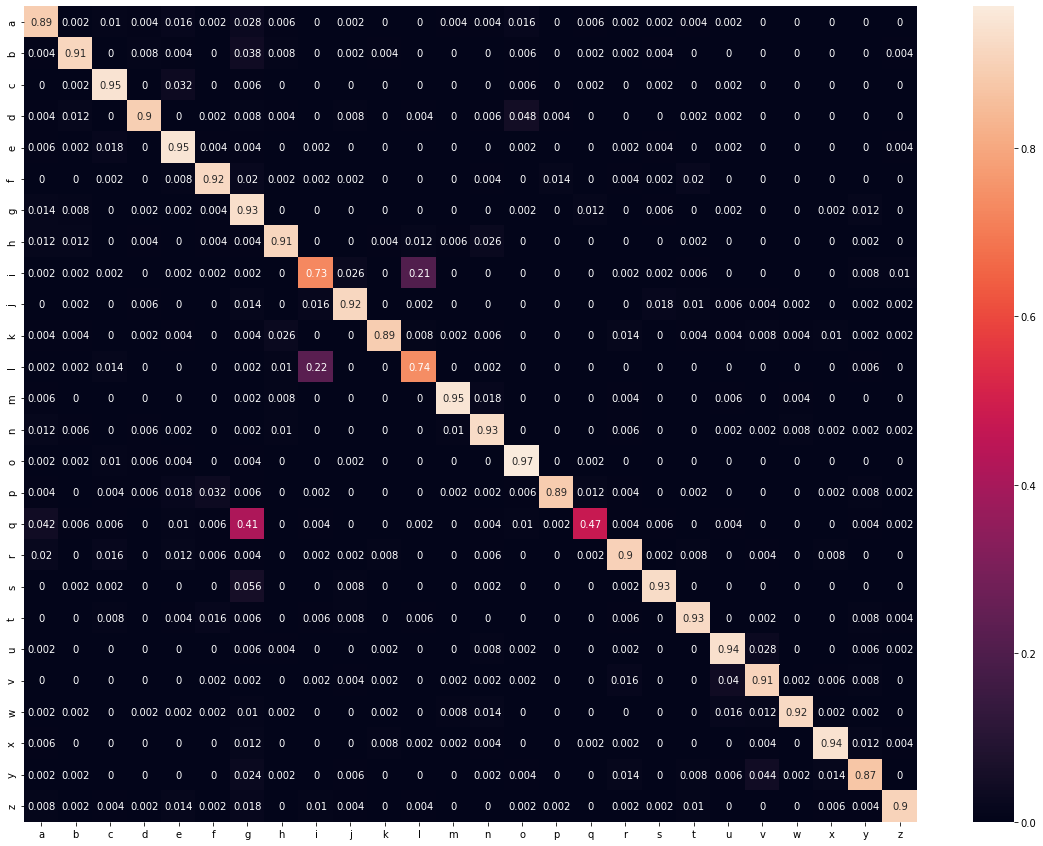

In [395]:
letter_labels = [get_letter_from_label(x) for x in range(26)]
cm_values = confusion_matrix(test_labels, test_predicted)
cm_df = pd.DataFrame(cm_values/np.sum(cm_values) * 26, 
                     index = letter_labels,
                     columns = letter_labels)
plt.figure(figsize = (20,15))
sns.heatmap(cm_df, annot=True)
plt.show()

In [396]:
cm_df.head()

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
a,0.890,0.002,0.010,0.004,0.016,0.002,0.028,0.006,0.000,0.002,...,0.006,0.002,0.002,0.004,0.002,0.0,0.0,0.0,0.0,0.000
b,0.004,0.914,0.000,0.008,0.004,0.000,0.038,0.008,0.000,0.002,...,0.002,0.002,0.004,0.000,0.000,0.0,0.0,0.0,0.0,0.004
c,0.000,0.002,0.948,0.000,0.032,0.000,0.006,0.000,0.000,0.000,...,0.002,0.000,0.002,0.000,0.002,0.0,0.0,0.0,0.0,0.000
d,0.004,0.012,0.000,0.896,0.000,0.002,0.008,0.004,0.000,0.008,...,0.000,0.000,0.000,0.002,0.002,0.0,0.0,0.0,0.0,0.000
e,0.006,0.002,0.018,0.000,0.950,0.004,0.004,0.000,0.002,0.000,...,0.000,0.002,0.004,0.000,0.002,0.0,0.0,0.0,0.0,0.004


### Most confusing letters

In [570]:
similarity_dict = dict()
for letter in letter_labels:
    most_similar = cm_df[letter].drop(letter).idxmax()
    similarity_value = cm_df[letter].loc[most_similar]
    similarity_dict[(letter, most_similar)] = similarity_value

similarity_dict = dict(sorted(similarity_dict.items(), key=lambda item: item[1], reverse=True))

top = 10
rows = []
i = 0
for key, value in similarity_dict.items():
    target, similar = key
    rows.append((target, similar, value))
    i += 1
    if i > top:
        break

print(tb(rows, headers=("Target", "Mess with", "Value"), tablefmt='fancy_grid'))

╒══════════╤═════════════╤═════════╕
│ Target   │ Mess with   │   Value │
╞══════════╪═════════════╪═════════╡
│ g        │ q           │   0.414 │
├──────────┼─────────────┼─────────┤
│ i        │ l           │   0.224 │
├──────────┼─────────────┼─────────┤
│ l        │ i           │   0.206 │
├──────────┼─────────────┼─────────┤
│ o        │ d           │   0.048 │
├──────────┼─────────────┼─────────┤
│ v        │ y           │   0.044 │
├──────────┼─────────────┼─────────┤
│ a        │ q           │   0.042 │
├──────────┼─────────────┼─────────┤
│ u        │ v           │   0.04  │
├──────────┼─────────────┼─────────┤
│ e        │ c           │   0.032 │
├──────────┼─────────────┼─────────┤
│ f        │ p           │   0.032 │
├──────────┼─────────────┼─────────┤
│ h        │ k           │   0.026 │
├──────────┼─────────────┼─────────┤
│ j        │ i           │   0.026 │
╘══════════╧═════════════╧═════════╛


#### Examples

In [528]:
test_dataset = LetterImageDataset(f"{DATASET_PATH}/test")

In [562]:
errors = {}
for real, predicted, i in zip(test_labels, test_predicted, range(len(test_labels))):
    if real != predicted:
        label_char = get_letter_from_label(real)
        if label_char not in errors:
            errors[label_char] = []
        errors[label_char].append(i)

Errors in predicting `Q`

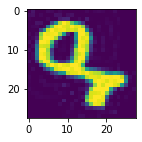

Predicted letter:  g 



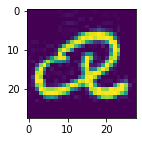

Predicted letter:  g 



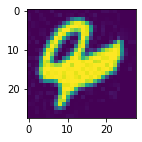

Predicted letter:  g 



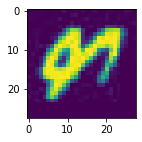

Predicted letter:  e 



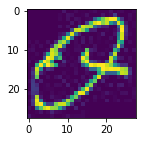

Predicted letter:  g 



In [568]:
errored_images_for_q = errors['q'][:5]
for error_index in errored_images_for_q:
    image_exmp, label_exmp = test_dataset[error_index]
    plt.figure(figsize=(2,2))
    plt.imshow(image_exmp[0].T)
    plt.show()
    print('Predicted letter: ', get_letter_from_label(test_predicted[error_index]), '\n')

Errors in predicting `I`

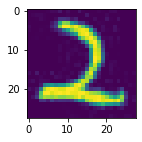

Predicted letter:  y 



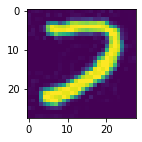

Predicted letter:  u 



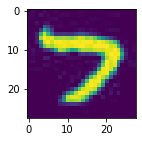

Predicted letter:  u 



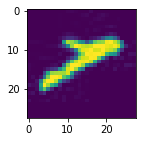

Predicted letter:  i 



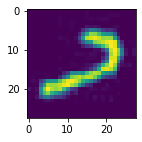

Predicted letter:  j 



In [567]:
errored_images_for_q = errors['v'][:5]
for error_index in errored_images_for_q:
    image_exmp, label_exmp = test_dataset[error_index]
    plt.figure(figsize=(2,2))
    plt.imshow(image_exmp[0].T)
    plt.show()
    print('Predicted letter: ', get_letter_from_label(test_predicted[error_index]), '\n')

### My name letter (A)

In [583]:
print("F1-score detection for letter A:\n", sorted_labels_metric['a'])

F1-score detection for letter A:
 0.8708414872798435


In [587]:
cm_df['a'].drop('a').sort_values(ascending=False)

q    0.042
r    0.020
g    0.014
n    0.012
h    0.012
z    0.008
e    0.006
m    0.006
x    0.006
d    0.004
p    0.004
b    0.004
k    0.004
o    0.002
l    0.002
i    0.002
u    0.002
w    0.002
y    0.002
c    0.000
s    0.000
t    0.000
v    0.000
j    0.000
f    0.000
Name: a, dtype: float64

Больше всего первую букву моего имени `A` путают с `q` , `r` и `g`

# Convolutional models

## 1Conv

In [455]:
class ConvClassifier1(nn.Module):
    def __init__(self, activation: str, hidden_size: int, 
                 conv_channels: list, pooling_channels: list,
                 conv_kernel: int, stride: int, padding: int):
        super().__init__()
        input_features = 28
        conv1_channels, = conv_channels
        pool1_channels, = pooling_channels
        output_features = 26
        self.activation = activation_map[activation]()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)

        self.pooling = nn.MaxPool2d(kernel_size=pool1_channels)
        flattened_size = ((input_features + 2 * padding - conv_kernel) // stride + 1) // pool1_channels
        self.linear1 = nn.Linear((flattened_size ** 2) * conv1_channels, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_features)

      
    def forward(self, x):
        # Convolution
        x = self.conv1(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling(x)
        # Linear
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [456]:
conv1_model = ConvClassifier1(activation="Tanh", hidden_size=128,
                              conv_channels=[18], pooling_channels=[4],
                              conv_kernel=5, stride=1, padding=0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv1_model.parameters(), lr=0.05)

In [410]:
train_model(conv1_model, criterion, optimizer, DATASET_PATH,
            epochs=10, batch_size=128, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/conv1_model_checkpoint"))

[ Epoch: 0 | Iteration: 0 | Loss train: 3.207034111022949 | Loss val: 3.2374045848846436 | Acc: 0.06715384615384615]
[ Epoch: 1 | Iteration: 500 | Loss train: 0.9559810161590576 | Loss val: 0.9878709316253662 | Acc: 0.7152307692307692]
[ Epoch: 2 | Iteration: 1000 | Loss train: 0.6365570425987244 | Loss val: 0.7112370133399963 | Acc: 0.7926923076923077]
[ Epoch: 3 | Iteration: 1500 | Loss train: 0.5270045399665833 | Loss val: 0.5398465394973755 | Acc: 0.8404615384615385]
[ Epoch: 4 | Iteration: 2000 | Loss train: 0.5231430530548096 | Loss val: 0.44482743740081787 | Acc: 0.8656153846153846]
[ Epoch: 6 | Iteration: 2500 | Loss train: 0.3605181872844696 | Loss val: 0.38992518186569214 | Acc: 0.8796923076923077]
[ Epoch: 7 | Iteration: 3000 | Loss train: 0.23084333539009094 | Loss val: 0.35263150930404663 | Acc: 0.8913846153846153]
[ Epoch: 8 | Iteration: 3500 | Loss train: 0.4141085147857666 | Loss val: 0.3310811519622803 | Acc: 0.8988461538461539]
[ Epoch: 9 | Iteration: 4000 | Loss trai

In [594]:
rows_samples = [
    [6, 3, 128, 10, 0.05, 0.62912736],
    [12, 3, 128, 10, 0.05, 0.76846153],
    [18, 5, 128, 10, 0.05, 0.90253846],
    [20, 5, 128, 10, 0.05, 0.90128348],
]
headers=('Conv channels', 'Kernel', 'Batch_size', 'Epochs', 'LR', 'Val Acc')
print("Tested configurations:")
print(tb(rows_samples, headers=headers, tablefmt='fancy_grid'))

Tested configurations:
╒═════════════════╤══════════╤══════════════╤══════════╤══════╤═══════════╕
│   Conv channels │   Kernel │   Batch_size │   Epochs │   LR │   Val Acc │
╞═════════════════╪══════════╪══════════════╪══════════╪══════╪═══════════╡
│               6 │        3 │          128 │       10 │ 0.05 │  0.629127 │
├─────────────────┼──────────┼──────────────┼──────────┼──────┼───────────┤
│              12 │        3 │          128 │       10 │ 0.05 │  0.768462 │
├─────────────────┼──────────┼──────────────┼──────────┼──────┼───────────┤
│              18 │        5 │          128 │       10 │ 0.05 │  0.902538 │
├─────────────────┼──────────┼──────────────┼──────────┼──────┼───────────┤
│              20 │        5 │          128 │       10 │ 0.05 │  0.901283 │
╘═════════════════╧══════════╧══════════════╧══════════╧══════╧═══════════╛


## 2Conv

In [457]:
class ConvClassifier2(nn.Module):
    def __init__(self, activation: str, hidden_size: int, 
                 conv_channels: list, pooling_channels: list,
                 conv_kernel: int, stride: int, padding: int):
        super().__init__()
        input_features = 28
        conv1_channels, conv2_channels = conv_channels
        pool1_channels, pool2_channels = pooling_channels
        output_features = 26
        self.activation = activation_map[activation]()
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)
        self.pooling1 = nn.MaxPool2d(kernel_size=pool1_channels)
        flattened_size1 = ((input_features + 2 * padding - conv_kernel) // stride + 1) // pool1_channels
        # Conv block 2
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)
        self.pooling2 = nn.MaxPool2d(kernel_size=pool2_channels)
        flattened_size2 = ((flattened_size1 + 2 * padding - conv_kernel) // stride + 1) // pool2_channels
        # Linear
        self.linear1 = nn.Linear((flattened_size2 ** 2) * conv2_channels, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 26)

      
    def forward(self, x):
        # Convolution1
        x = self.conv1(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling1(x)
        # Convolution2
        x = self.conv2(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling2(x)
        # Linear
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [459]:
conv2_model = ConvClassifier2(activation="Tanh", hidden_size=128,
                              conv_channels=[16, 8], pooling_channels=[2, 2],
                              conv_kernel=5, stride=1, padding=0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv2_model.parameters(), lr=0.05)

In [426]:
train_model(conv2_model, criterion, optimizer, DATASET_PATH,
            epochs=10, batch_size=128, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/conv2_model_checkpoint"))

[ Epoch: 0 | Iteration: 0 | Loss train: 3.2516393661499023 | Loss val: 3.250232696533203 | Acc: 0.047384615384615386]
[ Epoch: 1 | Iteration: 500 | Loss train: 0.8689720630645752 | Loss val: 1.0344473123550415 | Acc: 0.7113846153846154]
[ Epoch: 2 | Iteration: 1000 | Loss train: 0.7956033945083618 | Loss val: 0.7297812104225159 | Acc: 0.7893846153846154]
[ Epoch: 3 | Iteration: 1500 | Loss train: 0.5773496031761169 | Loss val: 0.6103278994560242 | Acc: 0.8213076923076923]
[ Epoch: 4 | Iteration: 2000 | Loss train: 0.5967115759849548 | Loss val: 0.4929088056087494 | Acc: 0.8501538461538461]
[ Epoch: 6 | Iteration: 2500 | Loss train: 0.43786442279815674 | Loss val: 0.4472373425960541 | Acc: 0.8655384615384616]
[ Epoch: 7 | Iteration: 3000 | Loss train: 0.9058207273483276 | Loss val: 0.4322502613067627 | Acc: 0.8683846153846154]
[ Epoch: 8 | Iteration: 3500 | Loss train: 0.3385147452354431 | Loss val: 0.39473456144332886 | Acc: 0.8777692307692307]
[ Epoch: 9 | Iteration: 4000 | Loss train

In [595]:
rows_samples = [
    [[12, 8], 3, 128, 10, 0.05, 0.85127384],
    [[16, 8], 5, 128, 10, 0.05, 0.88569230],
]
headers=('Conv channels', 'Kernel', 'Batch_size', 'Epochs', 'LR', 'Val Acc')
print("Tested configurations:")
print(tb(rows_samples, headers=headers, tablefmt='fancy_grid'))

Tested configurations:
╒═════════════════╤══════════╤══════════════╤══════════╤══════╤═══════════╕
│ Conv channels   │   Kernel │   Batch_size │   Epochs │   LR │   Val Acc │
╞═════════════════╪══════════╪══════════════╪══════════╪══════╪═══════════╡
│ [12, 8]         │        3 │          128 │       10 │ 0.05 │  0.851274 │
├─────────────────┼──────────┼──────────────┼──────────┼──────┼───────────┤
│ [16, 8]         │        5 │          128 │       10 │ 0.05 │  0.885692 │
╘═════════════════╧══════════╧══════════════╧══════════╧══════╧═══════════╛


## 3Conv

In [462]:
class ConvClassifier3(nn.Module):
    def __init__(self, activation: str, hidden_size: int, 
                 conv_channels: list, pooling_channels: list,
                 conv_kernel: int, stride: int, padding: int):
        super().__init__()
        input_features = 28
        # Convilutions
        conv1_channels, conv2_channels, conv3_channels = conv_channels
        pool1_channels, pool2_channels, pool3_channels = pooling_channels
        # Linearity
        output_features = 26
        self.activation = activation_map[activation]()
        # Conv block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)
        self.pooling1 = nn.MaxPool2d(kernel_size=pool1_channels)
        flattened_size1 = ((input_features + 2 * padding - conv_kernel) // stride + 1) // pool1_channels
        # Conv block 2
        self.conv2 = nn.Conv2d(in_channels=conv1_channels, out_channels=conv2_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)
        self.pooling2 = nn.MaxPool2d(kernel_size=pool2_channels)
        flattened_size2 = ((flattened_size1 + 2 * padding - conv_kernel) // stride + 1) // pool2_channels
        # Conv block 3
        self.conv3 = nn.Conv2d(in_channels=conv2_channels, out_channels=conv3_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)
        self.pooling3 = nn.MaxPool2d(kernel_size=pool3_channels)
        flattened_size3= ((flattened_size2 + 2 * padding - conv_kernel) // stride + 1) // pool3_channels
        # Linear
        self.linear1 = nn.Linear((flattened_size3 ** 2) * conv3_channels, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_features)

      
    def forward(self, x):
        # Convolution1
        x = self.conv1(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling1(x)
        # Convolution2
        x = self.conv2(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling2(x)
        # Convolution3
        x = self.conv3(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling3(x)
        # Linear
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [468]:
conv3_model = ConvClassifier3(activation="Tanh", hidden_size=128,
                              conv_channels=[32,16,12], pooling_channels=[2, 2, 2],
                              conv_kernel=3, stride=1, padding=0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv3_model.parameters(), lr=0.05)

In [469]:
train_model(conv3_model, criterion, optimizer, DATASET_PATH,
            epochs=10, batch_size=128, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/conv3_model_checkpoint"))

[ Epoch: 0 | Iteration: 0 | Loss train: 3.2974801063537598 | Loss val: 3.2682080268859863 | Acc: 0.04376923076923077]
[ Epoch: 1 | Iteration: 500 | Loss train: 1.623966932296753 | Loss val: 1.7906320095062256 | Acc: 0.5114615384615384]
[ Epoch: 2 | Iteration: 1000 | Loss train: 1.3242284059524536 | Loss val: 1.163906455039978 | Acc: 0.6600769230769231]
[ Epoch: 3 | Iteration: 1500 | Loss train: 1.1973562240600586 | Loss val: 0.9475332498550415 | Acc: 0.7111538461538461]
[ Epoch: 4 | Iteration: 2000 | Loss train: 0.6096456050872803 | Loss val: 0.8115696907043457 | Acc: 0.7466153846153846]
[ Epoch: 6 | Iteration: 2500 | Loss train: 0.8843258023262024 | Loss val: 0.755254328250885 | Acc: 0.7598461538461538]
[ Epoch: 7 | Iteration: 3000 | Loss train: 0.6044405698776245 | Loss val: 0.7066588401794434 | Acc: 0.7771538461538462]
[ Epoch: 8 | Iteration: 3500 | Loss train: 0.5922514200210571 | Loss val: 0.6749661564826965 | Acc: 0.7847692307692308]
[ Epoch: 9 | Iteration: 4000 | Loss train: 0.5

In [596]:
rows_samples = [
    [[16, 8, 4], 3, 128, 10, 0.05, 0.68126361],
    [[32,16,12], 3, 128, 10, 0.05, 0.79607692],
]
headers=('Conv channels', 'Kernel', 'Batch_size', 'Epochs', 'LR', 'Val Acc')
print("Tested configurations:")
print(tb(rows_samples, headers=headers, tablefmt='fancy_grid'))

Tested configurations:
╒═════════════════╤══════════╤══════════════╤══════════╤══════╤═══════════╕
│ Conv channels   │   Kernel │   Batch_size │   Epochs │   LR │   Val Acc │
╞═════════════════╪══════════╪══════════════╪══════════╪══════╪═══════════╡
│ [16, 8, 4]      │        3 │          128 │       10 │ 0.05 │  0.681264 │
├─────────────────┼──────────┼──────────────┼──────────┼──────┼───────────┤
│ [32, 16, 12]    │        3 │          128 │       10 │ 0.05 │  0.796077 │
╘═════════════════╧══════════╧══════════════╧══════════╧══════╧═══════════╛


## Validating best model

Модель с 1 сверточным слоем показала лучшие результаты на Валидации во время тренировки

In [440]:
test_labels, test_predicted = test_validation(conv1_model, DATASET_PATH, labels=list(range(26)), batch_size=128)

+=======================================+
|             TEST RESULTS              |
+=======================================+
Metric      Scores
--------  --------
Accuracy  0.901692
F1        0.953234
classification_report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       500
           1       0.93      0.95      0.94       500
           2       0.94      0.93      0.93       500
           3       0.91      0.94      0.92       500
           4       0.90      0.95      0.92       500
           5       0.94      0.92      0.93       500
           6       0.75      0.82      0.78       500
           7       0.93      0.92      0.93       500
           8       0.75      0.64      0.69       500
           9       0.87      0.93      0.90       500
          10       0.95      0.93      0.94       500
          11       0.74      0.78      0.76       500
          12       0.94      0.96      0.95       500
          13      

## Best Convolutional Classifier with batch normalization

In [470]:
class ConvClassifierBestNorm(nn.Module):
    def __init__(self, activation: str, hidden_size: int, 
                 conv_channels: list, pooling_channels: list,
                 conv_kernel: int, stride: int, padding: int):
        super().__init__()
        input_features = 28
        conv1_channels, = conv_channels
        pool1_channels, = pooling_channels
        output_features = 26
        self.activation = activation_map[activation]()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=conv1_channels, 
                               kernel_size=conv_kernel,
                               stride=stride, padding=padding)
        self.conv_bn = nn.BatchNorm2d(conv1_channels)
        self.pooling = nn.MaxPool2d(kernel_size=pool1_channels)
        flattened_size = ((input_features + 2 * padding - conv_kernel) // stride + 1) // pool1_channels
        self.linear1 = nn.Linear((flattened_size ** 2) * conv1_channels, hidden_size)
        self.linear_bn = nn.BatchNorm1d(hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_features)

      
    def forward(self, x):
        # Convolution
        x = self.conv1(x)
        x = self.conv_bn(x)
        x = self.activation(x)
        # Pooling
        x = self.pooling(x)
        # Linear
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear_bn(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

In [473]:
conv_best_bn_model = ConvClassifierBestNorm(activation="Tanh", hidden_size=128,
                                            conv_channels=[18], pooling_channels=[4],
                                            conv_kernel=5, stride=1, padding=0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_best_bn_model.parameters(), lr=0.05)

Up batch size to 192 and epochs to 15

In [474]:
train_model(conv_best_bn_model, criterion, optimizer, DATASET_PATH,
            epochs=15, batch_size=192, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/conv_best_bn_model_checkpoint"))

[ Epoch: 0 | Iteration: 0 | Loss train: 3.230365037918091 | Loss val: 3.2247214317321777 | Acc: 0.07161538461538461]
[ Epoch: 1 | Iteration: 500 | Loss train: 0.9408041834831238 | Loss val: 0.7921115159988403 | Acc: 0.7826923076923077]
[ Epoch: 3 | Iteration: 1000 | Loss train: 0.5852131843566895 | Loss val: 0.48347753286361694 | Acc: 0.8620769230769231]
[ Epoch: 5 | Iteration: 1500 | Loss train: 0.32882240414619446 | Loss val: 0.40011388063430786 | Acc: 0.8803076923076923]
[ Epoch: 7 | Iteration: 2000 | Loss train: 0.3298914134502411 | Loss val: 0.3579240143299103 | Acc: 0.8922307692307693]
[ Epoch: 9 | Iteration: 2500 | Loss train: 0.40584447979927063 | Loss val: 0.33267703652381897 | Acc: 0.8994615384615384]
[ Epoch: 11 | Iteration: 3000 | Loss train: 0.28545618057250977 | Loss val: 0.3124059736728668 | Acc: 0.9041538461538462]
[ Epoch: 12 | Iteration: 3500 | Loss train: 0.20178444683551788 | Loss val: 0.30202817916870117 | Acc: 0.9085384615384615]
[ Epoch: 14 | Iteration: 4000 | Lo

In [475]:
test_labels, test_predicted = test_validation(conv_best_bn_model, DATASET_PATH, labels=list(range(26)), batch_size=128)

+=======================================+
|             TEST RESULTS              |
+=======================================+
Metric      Scores
--------  --------
Accuracy  0.903077
F1        0.965235
classification_report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       500
           1       0.95      0.89      0.92       500
           2       0.96      0.94      0.95       500
           3       0.94      0.89      0.92       500
           4       0.92      0.95      0.93       500
           5       0.94      0.93      0.94       500
           6       0.66      0.86      0.74       500
           7       0.94      0.91      0.93       500
           8       0.74      0.72      0.73       500
           9       0.94      0.91      0.92       500
          10       0.96      0.92      0.94       500
          11       0.74      0.76      0.75       500
          12       0.94      0.97      0.95       500
          13      

Модель с бОльшим `batch_size` и слоями `BatchNorm` показала результаты чуть лучше, чем оригинальная сверточная модель:  

              NoBatchNorm                  BatchNorm
            Accuracy  0.901692        Accuracy  0.903077
            F1        0.953234        F1        0.965235

# Pretrained models and Transfer learning

In [597]:
import torchvision.models as models

In [600]:
input_features = 28
out_features = 26

## ResNet

In [598]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/sanduser/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


Остановить распределение ошибки для предобученных слоев и  
создать новый выходной слой, подходящий для решения нашей задачи

In [599]:
for param in resnet.parameters():
    param.requires_grad = False

In [601]:
resnet.fc = nn.Linear(512, out_features)

In [602]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.05)

In [607]:
train_model(resnet, criterion, optimizer, DATASET_PATH,
            epochs=5, batch_size=128, train_split_precent=0.8,
            report_step=500,
            checkpoint_path=os.path.abspath("./checkpoints/resnet_frizzed_checkpoint"),
            gray_scale=False)

[ Epoch: 0 | Iteration: 0 | Loss train: 3.3205127716064453 | Loss val: 3.3546273708343506 | Acc: 0.03915384615384616]
[ Epoch: 1 | Iteration: 500 | Loss train: 2.1776208877563477 | Loss val: 2.0272560119628906 | Acc: 0.42615384615384616]
[ Epoch: 2 | Iteration: 1000 | Loss train: 1.835161805152893 | Loss val: 1.5292153358459473 | Acc: 0.5631538461538461]
[ Epoch: 3 | Iteration: 1500 | Loss train: 1.4502171277999878 | Loss val: 1.448178768157959 | Acc: 0.5802307692307692]
[ Epoch: 4 | Iteration: 2000 | Loss train: 1.2670063972473145 | Loss val: 1.4313162565231323 | Acc: 0.5858461538461538]
Finished Training


In [609]:
test_labels, test_predicted = test_validation(resnet, DATASET_PATH, labels=list(range(26)), batch_size=128, gray_scale=False)

+=======================================+
|             TEST RESULTS              |
+=======================================+
Metric      Scores
--------  --------
Accuracy  0.556538
F1        0.737406
classification_report:
              precision    recall  f1-score   support

           0       0.37      0.45      0.40       500
           1       0.53      0.39      0.45       500
           2       0.65      0.65      0.65       500
           3       0.65      0.66      0.65       500
           4       0.69      0.44      0.54       500
           5       0.76      0.11      0.19       500
           6       0.36      0.46      0.40       500
           7       0.74      0.39      0.51       500
           8       0.32      0.83      0.46       500
           9       0.68      0.48      0.56       500
          10       0.47      0.69      0.56       500
          11       0.57      0.37      0.45       500
          12       0.92      0.70      0.80       500
          13      

In [610]:
report = classification_report(test_labels, test_predicted, output_dict=True)
sorted_labels_metric = {get_letter_from_label(key): report[str(key)]['f1-score'] for key in range(26)}
sorted_labels_metric = dict(sorted(sorted_labels_metric.items(), key=lambda item: item[1], reverse=True))
sorted_labels_metric_list = [(key, value) for key, value in sorted_labels_metric.items()]
sorted_labels_metric

{'m': 0.7963800904977375,
 'o': 0.7724550898203593,
 'x': 0.7558011049723756,
 'w': 0.7374062165058949,
 'z': 0.7020109689213895,
 'd': 0.6534653465346535,
 'c': 0.6487562189054727,
 'u': 0.6474226804123712,
 's': 0.6146496815286625,
 'v': 0.6075558982266769,
 't': 0.562019758507135,
 'j': 0.5603751465416178,
 'k': 0.5566343042071197,
 'e': 0.5385556915544675,
 'p': 0.5280373831775701,
 'h': 0.5065616797900262,
 'y': 0.5019011406844107,
 'n': 0.4748646558391338,
 'q': 0.45922746781115875,
 'i': 0.4589983489268025,
 'b': 0.45287356321839084,
 'l': 0.4452554744525547,
 'a': 0.4039675383228134,
 'r': 0.40320733104238254,
 'g': 0.40247131509267436,
 'f': 0.18914185639229422}

К сожалению, использование претренерованной модели не привело к хорошим результатам, однако заметно, что распределение метрик относительно букв немного поменялись

# Hyperparameters automatic tuning (unused)

Изначально написал систему, благодаря который можно было автоматически подрбирать параметры, но у меня это работало, к сожалению, слишком долго

In [223]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [127]:
def find_best_model(model_class: torch.nn.Module,
                    tune_params: dict, 
                    static_config: dict,
                    model_config_names: list,
                    data_dir: str, checkpoint_dir: str):
      # Define search algorithm
      scheduler = ASHAScheduler(
          metric="loss",
          mode="min",
          max_t=static_config['epochs'],
          grace_period=1,
          reduction_factor=2)
      # Define reporter
      reporter = CLIReporter(
          metric_columns=["loss", "metric", "training_iteration"])
      # Report static configurations
      static_config_rows = [(key, value) for key, value in static_config.items()]
      print("Static configurations:")
      print(tb(static_config_rows, headers=('Config', 'Value')))
      # Find best hyperparams
      train_params = partial(train_model_tuning,
                             model_class=model_class,
                             static_config=static_config,
                             model_config_names=model_config_names,
                             data_dir=data_dir, checkpoint_dir=checkpoint_dir)
      result = tune.run(
          train_params,
          config=tune_params,
          num_samples=static_config['model_samples_num'],
          scheduler=scheduler,
          progress_reporter=reporter)

      # Validate best model on Test dataset
      best_trial = result.get_best_trial("loss", "min", "last")
      print("Best trial config: {}".format(best_trial.config))
      print("Best trial final validation loss: {}".format(
          best_trial.last_result["loss"]))
      print("Best trial final validation metric: {}".format(
          best_trial.last_result["metric"]))

      # Load best model found
      best_model_hyperparams = {key: best_trial.config[key] for key in model_config_names}
      best_trained_model = model_class(**best_model_hyperparams)

      # Choose device
      device = "cpu" if not torch.cuda.is_available() else "cuda:0"
      best_trained_model.to(device)

      best_checkpoint_dir = best_trial.checkpoint.value
      model_state, optimizer_state = torch.load(os.path.join(
          best_checkpoint_dir, "checkpoint"))
      best_trained_model.load_state_dict(model_state)

      return best_trained_model

In [145]:
def train_model_tuning(config: dict, 
                       model_class: torch.nn.Module, 
                       static_config: dict,
                       model_config_names: list,
                       data_dir: str, checkpoint_dir: str):

  def checkpoint_saver(model, optimizer, epoch):
    with tune.checkpoint_dir(epoch) as checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save((model.state_dict(), optimizer.state_dict()), path)

  def reporter(loss, metric):
    tune.report(loss=loss, metric=metric)
  
  # Create network
  model_hyperparams = {key: config[key] for key in model_config_names}
  model = model_class(**model_hyperparams)

  # Chose training hyperparams
  criterion = static_config['criterion']()
  optimizer = static_config['optimizer'](model.parameters(), lr=config["lr"])

  train_model(model, 
              criterion, optimizer, data_dir,
              static_config['epochs'], config['batch_size'], 
              static_config['train_split_percent'], static_config['report_step'],
              checkpoint_saver, reporter)


In [161]:
static_config = {
    'criterion': nn.CrossEntropyLoss,
    'optimizer': torch.optim.SGD,
    'train_split_percent': 0.8,
    'epochs': 2,
    'report_step': 1000,
    'cls_labels': list(range(0, 26)),
    'model_samples_num': 1,
}

tune_params = {
    'hidden1': tune.choice([256]),
    'hidden2': tune.choice([128]),
    'activation': tune.choice(["ReLU"]),
    'dropout': tune.choice([0.2]),
    'lr': tune.choice([0.05]),
    'batch_size': tune.choice([128]),
}

model_config_names = ['hidden1', 'hidden2', 'activation', 'dropout']

In [162]:
best_linear = find_best_model(model_class=LinearClassifier, 
                              tune_params=tune_params, static_config=static_config, 
                              model_config_names=model_config_names, 
                              data_dir=DATASET_PATH, checkpoint_dir=None)

2021-12-01 19:14:50,106	WARNING experiment.py:271 -- No name detected on trainable. Using DEFAULT.
2021-12-01 19:14:50,148	INFO registry.py:69 -- Detected unknown callable for trainable. Converting to class.


Static configurations:
Config               Value
-------------------  ----------------------------------------------------------------------------------------------
criterion            <class 'torch.nn.modules.loss.CrossEntropyLoss'>
optimizer            <class 'torch.optim.sgd.SGD'>
train_split_percent  0.8
epochs               2
report_step          1000
cls_labels           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
model_samples_num    1
== Status ==
Current time: 2021-12-01 19:14:50 (running for 00:00:00.14)
Memory usage on this node: 6.0/8.0 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/2.33 GiB heap, 0.0/1.17 GiB objects
Result logdir: /Users/sanduser/ray_results/DEFAULT_2021-12-01_19-14-50
Number of trials: 1/1 (1 PENDING)
+---------------------+----------+-------+--------------+--------------+-----------+-----------+-----------+------+
| Tri

2021-12-01 19:16:58,136	WARNING tune.py:586 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 
(pid=42139) 2021-12-01 19:16:58,167	ERROR worker.py:425 -- SystemExit was raised from the worker
(pid=42139) Traceback (most recent call last):
(pid=42139)   File "python/ray/_raylet.pyx", line 692, in ray._raylet.task_execution_handler
(pid=42139)   File "python/ray/_raylet.pyx", line 521, in ray._raylet.execute_task
(pid=42139)   File "python/ray/_raylet.pyx", line 558, in ray._raylet.execute_task
(pid=42139)   File "python/ray/_raylet.pyx", line 565, in ray._raylet.execute_task
(pid=42139)   File "python/ray/_raylet.pyx", line 569, in ray._raylet.execute_task
(pid=42139)   File "python/ray/_raylet.pyx", line 519, in ray._raylet.execute_task.function_executor
(pid=42139)   File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pack

== Status ==
Current time: 2021-12-01 19:16:58 (running for 00:02:07.95)
Memory usage on this node: 6.0/8.0 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 2.000: None | Iter 1.000: -3.258077301231085
Resources requested: 1.0/4 CPUs, 0/0 GPUs, 0.0/2.33 GiB heap, 0.0/1.17 GiB objects
Result logdir: /Users/sanduser/ray_results/DEFAULT_2021-12-01_19-14-50
Number of trials: 1/1 (1 RUNNING)
+---------------------+----------+-----------------+--------------+--------------+-----------+-----------+-----------+------+---------+-----------+----------------------+
| Trial name          | status   | loc             | activation   |   batch_size |   dropout |   hidden1 |   hidden2 |   lr |    loss |    metric |   training_iteration |
|---------------------+----------+-----------------+--------------+--------------+-----------+-----------+-----------+------+---------+-----------+----------------------|
| DEFAULT_cf4e8_00000 | RUNNING  | 127.0.0.1:42139 | ReLU         |          128 |       0.2

2021-12-01 19:16:58,364	ERROR tune.py:626 -- Trials did not complete: [DEFAULT_cf4e8_00000]
2021-12-01 19:16:58,366	INFO tune.py:630 -- Total run time: 128.28 seconds (127.94 seconds for the tuning loop).
2021-12-01 19:16:58,367	WARNING tune.py:634 -- Experiment has been interrupted, but the most recent state was saved. You can continue running this experiment by passing `resume=True` to `tune.run()`


Best trial config: {'hidden1': 256, 'hidden2': 128, 'activation': 'ReLU', 'dropout': 0.2, 'lr': 0.05, 'batch_size': 128}
Best trial final validation loss: 3.258077301231085
Best trial final validation metric: 0.046384615384615385
